# Fenomenological Waveform

### To start we introduce the variables that we are going to use 

In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Thu Sep 16 23:12:07 2021

@author: cesartiznado
"""
import numpy as np
from matplotlib import pyplot as plt
import scipy.signal as sg
import pandas as pd
from scipy import interpolate
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec
from sn_library import *
# =============================================================================

# =================== Inicial variables

def cond(Fm,t_ini,t_end,f_0,f_1,t_2,f_driver,Q,OG):
    """
    Fm: Frecuencia de muestreo, 
    t_ini:Tiempo inicial, 
    t_end:Tiempo final,
    f_0: Frecuencia inicial,
    f_1: Frecuencia s=1,
    t_2: Tiempo> Final,
    f_driver: Frecuencia del forzamiento,
    Q: Factor de calidad,
    ran_seed: Semilla aleatoria,
    OG: Número de la WF que utilizamos
    """
    dt = 1/Fm
    N  = np.arange(t_ini,t_end,dt) 
    n  = int(f_driver/(t_end-t_ini))
    t_n1 = rng.uniform(t_ini,t_end,n) #Set the uniform distribution of t_n
    t_n = np.sort(t_n1)       # t_n in progresive order
    t_s = np.arange(t_ini,t_end,dt) #Time in the inicial interval (simple)
    f = np.zeros(len(t_s))    # Set memory to get the frequency
    p_2 = np.zeros(len(t_s))  # Set memory to p_2
    w = np.zeros(len(t_s))    # Set memory to angular frequency
    
    
    for i in range(0,len(t_s)):
        p_1    =  f_1 - f_0 
        p_3    =  t_2 - t_ini
        ab     = (2*t_2-t_ini-1)*(1-t_ini)
        p_2[i] = t_s[i]-t_ini
        f[i] = f_0 + 2*p_1*p_3*(p_2[i])/(ab) - p_1*(p_2[i])**2/(ab)
        w[i] = 2*np.pi*f[i]
    
    return Fm,N,n,t_s,t_n,t_n1,f,w,Q,dt,t_ini,t_end,OG

### Introduce The Dirac's Delta implementation, who's going to be the forcing in our function.

In [2]:
# =================== Delta implementation

def delta_imp():
    a_n1 = rng.uniform(-1,1,n) 
    a_n1 =a_n1 *t_n
    a = np.zeros((len(t_s)))
    for i in range(0,len(t_s)):
        for j in range(0,n):
            #s[i,j] =  t_s[i]-t_n[j]
            #a[i] = np.minimum(s[i,:])
            if t_s[i]-t_n[j]<=0 and t_s[i]-t_n[j]>=-1e-4 :     #if t_s1[i]-t_n[j]<=0 and t_s1[i]-t_n[j]>=-1e-4
                #print("-")
                a[i] = a_n1[j]
                i+=1
    return a,a_n1

### Model implementation

In [3]:
# ============== Model Implementation

def model(): 
    h_t = np.zeros(len(t_s))
    h = np.zeros(len(t_s))
    def F(a,h_t,h,w):
        return a - (w/Q)*h_t - (w**2)*h
    for i in range(0,len(t_s)):
        h_t[i] = h_t[i-1] + F(a[i-1],h_t[i-1],h[i-1],w[i-1])*dt
        h[i] = h[i-1] + h_t[i-1]*dt
    # hrms = 1e13
    # h = h/hrms
    # h = h/2
    h = h/max(abs(h))
    return h

### Resample of the data 

In [4]:
# ========================== Resample to 16386

sample = 16386
def sn_resample_wave(t,h,fs):
    """
    Interpolate array h to the fs sampling frequency.
    Input:
        t  - time array, in seconds
        h  - strain array to be interpolated
        fs - thi is the new sampling frequency
    Output:
        t1 - time array, after resampling
        h1 - new strain array
    """
    # Quick check
    if len(t)!=len(h):
        print("Error: t and h need to have equal sizes")
        return 0
    # Define new time with fs
    t1 = np.arange(t[0],t[-1],1.0/fs)
    # Interpolation
    tck = interpolate.splrep(t,h,s=0)
    h1  = interpolate.splev(t1,tck,der=0)
   
    return t1, h1

### Padding zeros to the signal

In [5]:
# ================ Add zeros to the angular frequeny,frequency, the signal and time
def pad_zeros():
    tright = np.arange(t_end,1.0,dt)
    tz = np.append(t_s,tright)
        
    hsr = np.zeros(len(tright))
    hz  = np.append(h,hsr)
    
    wr = np.zeros(len(tright))
    wz = np.append(w,wr)
    
    fr = np.zeros(len(tright))
    fz = np.append(f,fr)
    return tz,wz,fz,hz

### Save the data in a .csv file . 

In [5]:
def save(datog):
    datog = pd.DataFrame()
    datog["Time"] = tz
    datog["Frequency"] = fz
    datog["Signal"] = hz
    # datog["SG_Time"] = t
    # datog["SG_Strain"] = hx_SG
    return datog.to_csv("Dato_"+str(OG)+".csv",header=True,index = False)

## Set the initial conditions of the template

In [6]:
# =============================================================================
# Inicial Conditions of our Perturbartion
# =============================================================================
# =============== WF_1
#Fm,N,n,t_s,t_n,f,w,Q,dt,t_ini,t_end,OG = cond(200000,0.0,0.5,100,1100,.6,600,10,8,1)

# =============== WF_2
#Fm,N,n,t_s,t_n,f,w,Q,dt,t_ini,t_end,OG = cond(200000,0.0,0.2,100,400,.4,100,1,8,2)

# =============== WF_3
seed= 8 
rng = np.random.default_rng(seed = seed)
Fm,N,n,t_s,t_n,t_n1,f,w,Q,dt,t_ini,t_end,OG = cond(200000,0.0,0.5,100,700,1.25,200,10,3)

# =============== WF_4

#Fm,N,n,t_s,t_n,f,w,Q,dt,t_ini,t_end,OG = cond(200000,0.2,0.9,300,1400,1.2,400,10,8,4)

# =============== WF_5
#Fm,N,n,t_s,t_n,f,w,Q,dt,t_ini,t_end,OG = cond(200000,0.1,0.6,150,800,.8,250,1,8,5)

### Execute All the functions to a determinate values.

In [7]:
# =============================================================================
# Call de functions to execute the instructions
# =============================================================================

a,a_n1  = delta_imp()                  #Dirac Delta
h = model()                            #Waveform
t_sres,h_res = sn_resample_wave(t_s,h,sample) #Resample to LIGO frequency
#tz,wz,fz,hz = pad_zeros()              #Paddig zeros to the signal 
#hp = wfSG(sample)                      #hp polarization in Sine Gaussian waveforms

### Set parameters to the graphs

In [8]:
plt.rcParams.update(plt.rcParamsDefault)
size=17
params = {'legend.fontsize': 'large',
          'figure.figsize': (8,5),
          'axes.labelsize': size,
          'axes.titlesize': size,
          'xtick.labelsize': size*0.8,
          'ytick.labelsize': size*0.8,
          'legend.fontsize': size*0.8,
          'axes.titlepad': 7,
          'font.family': 'serif',
          'font.weight': 'medium',
          'xtick.major.size': 10,
          'ytick.major.size': 10,
          'xtick.minor.size': 5,
          'ytick.minor.size': 5
          }
plt.rcParams.update(params)

### We would determinate the Hrss and Scale or function.
Remember that $hrss$ obeys $h_{rss} \equiv \sqrt{\int{h(t)^{2} dt}}$  


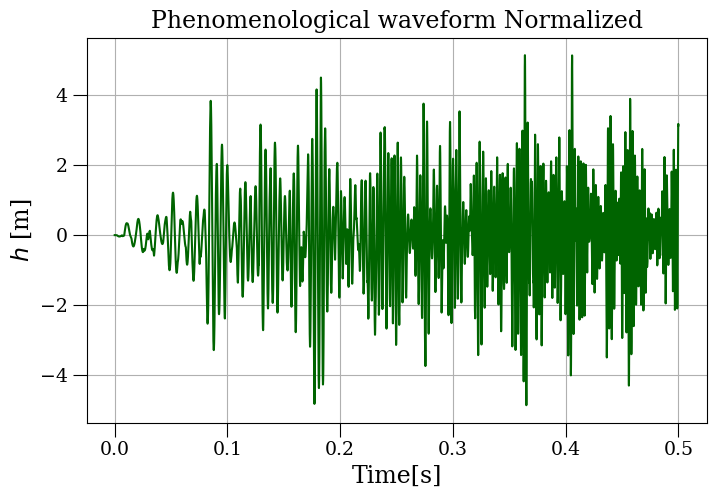

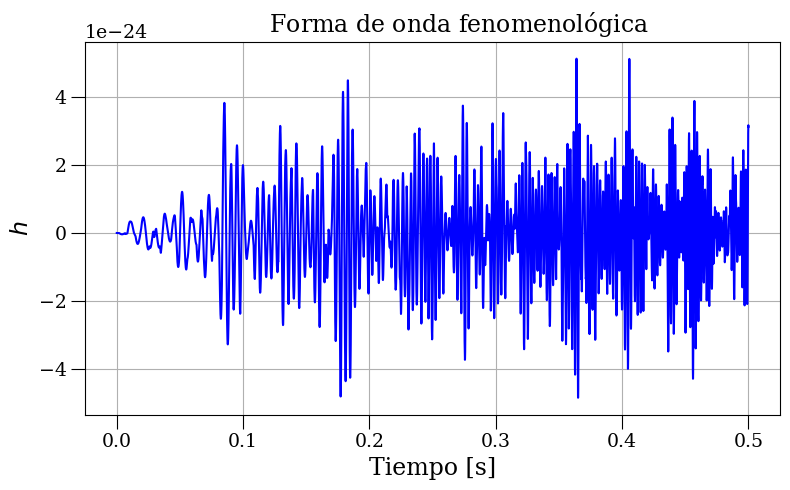

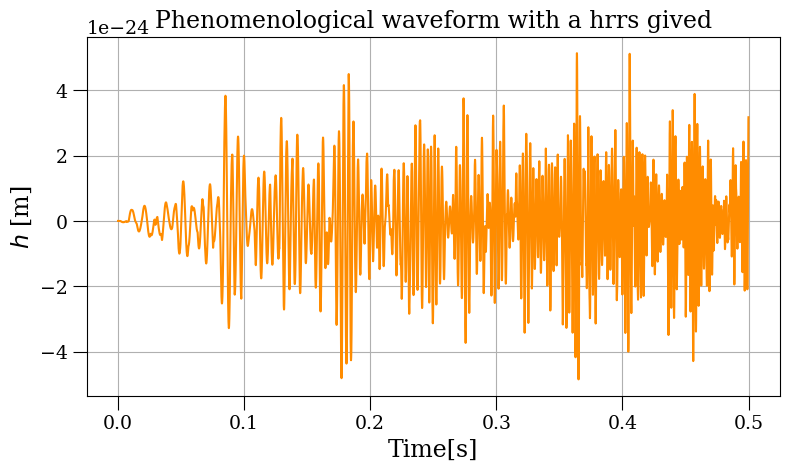

In [9]:
from sn_library import *
hrss_calc   = sn_hrss_wave(t_s,h,np.zeros(len(h))) #hrss calculated from our WF
ht = h / hrss_calc #Scale on h(t) #WF Normalized
hrss_th = sn_hrss_wave(t_s,ht,np.zeros(len(ht)))
hrss_g = 1e-24 #sn_hrss_wave(t_s,ht,np.zeros(len(ht)))# The hrss that we want oru signal have
hsc = ht * hrss_g #The model with the respective hrss
hmcs = sn_hrss_wave(t_sres,h_res,np.zeros(len(h_res)))
plt.plot(t_s,ht,color="darkgreen")
plt.title("Phenomenological waveform Normalized")
plt.ylabel('$h$ [m]')
plt.xlabel("Time[s]")
plt.grid()
#plt.savefig("Desktop\\Tesis\\Fen_tiz\\Images" + "WFN.png",dpi=400)
plt.show()

plt.plot(t_s,hsc,color="blue",label="$h_{e} = 1x10^{-24}$")
# plt.title("Phenomenological waveform with a hrrs gived")
plt.title("$\qquad $ Forma de onda fenomenológica")
plt.ylabel('$h$')
plt.xlabel("Tiempo [s]")
plt.grid()
plt.tight_layout()
plt.show()

t_sres1,h_res1 = sn_resample_wave(t_s,hsc,16384) #Resample to LIGO frequency
plt.plot(t_sres1,h_res1,color="darkorange")
plt.title("Phenomenological waveform with a hrrs gived")
plt.ylabel('$h$ [m]')
plt.xlabel("Time[s]")
plt.grid()
plt.tight_layout()
plt.show()

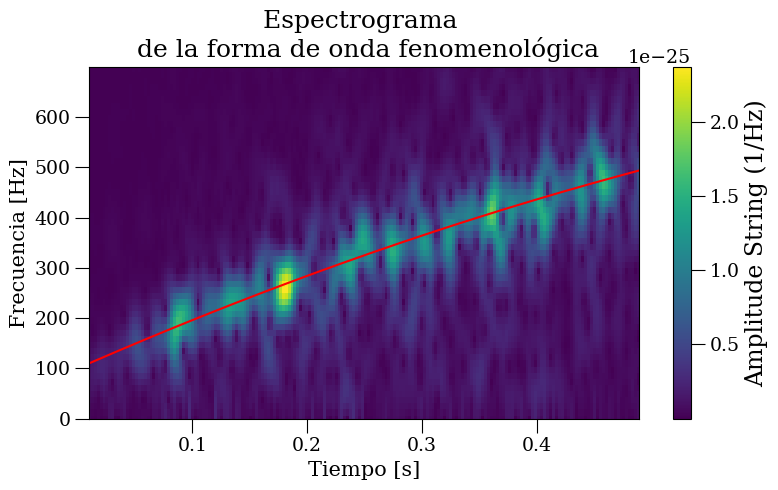

In [10]:
# =========================== Plot Spectrogram
wnd="hamming"
nfft=4*4096
nperseg=4096
noverlap=4096-512

fxx, txx, Sxx = sg.spectrogram(hsc, Fm, window=wnd, nfft=nfft, nperseg=nperseg, noverlap=noverlap, mode='magnitude')


plt.figure()
plt.pcolormesh(txx, fxx, Sxx,shading="auto")
plt.plot(t_s,f,"r")
# plt.title("Spectrogram of the WF No." + str(OG),fontsize=18)
plt.title("Espectrograma \n de la forma de onda fenomenológica",fontsize=18)
cbar = plt.colorbar()
cbar.set_label('Amplitude String (1/Hz)')
plt.ylim([0,max(f) +200])
plt.ylabel('Frecuencia [Hz]',fontsize=15)
plt.xlabel('Tiempo [s]',fontsize=15)
plt.xlim(min(txx),max(txx))
plt.tight_layout()
#plt.savefig(path + "Spec_WF_No"+ str(OG) + ".png",dpi=400)
plt.show()


# Plot the Spectrogram of the Waveform.

In [11]:
# ===================== Spectrogram

wnd="hamming"
nfft=4*4096
nperseg=4096
noverlap=4096-512

def spectrogram(h,Fm):
    """ Función para la creación del espectrograma
    h: Señal
    Fm: Frecuencia de Muestreo
    """
    f,t,Sxx = sg.spectrogram(h, Fm, window=wnd, nfft=nfft, nperseg=nperseg, noverlap=noverlap, mode='magnitude')
    return f,t,Sxx    


fxx, txx, Sxx = sg.spectrogram(h, Fm, window=wnd, nfft=nfft, nperseg=nperseg, noverlap=noverlap, mode='magnitude')

resfxx,restxx,resSxx = sg.spectrogram(h, sample, window=wnd, nfft=nfft, nperseg=nperseg, noverlap=noverlap, mode='magnitude')
#txx = txx + t_sres[0] # Recorrer el espectrograma

## Create a directory to the images and plot all of them

C:\Users\PC\Desktop\Tesis\Fen_tiz
C:\Users\PC\Desktop\Tesis\Fen_tiz\Images\
The directory: {0} C:\Users\PC\Desktop\Tesis\Fen_tiz\Images\ Already exist


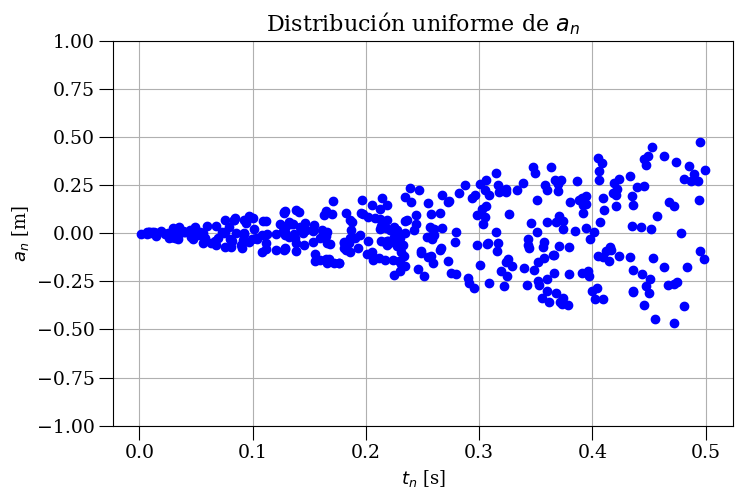

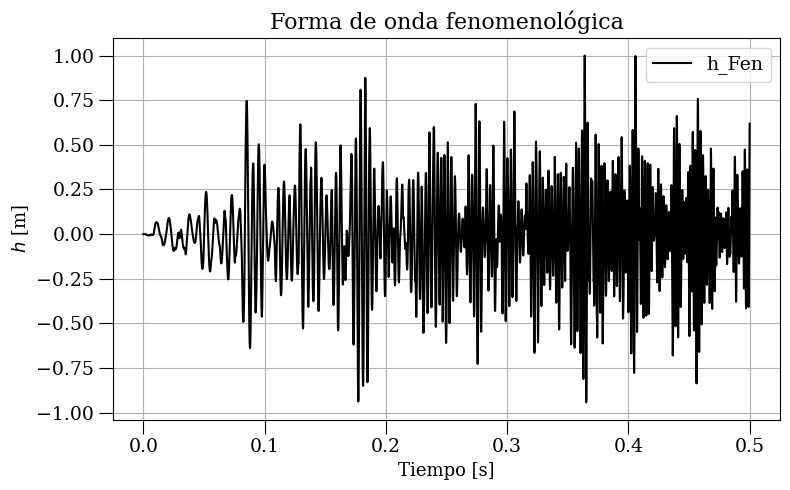

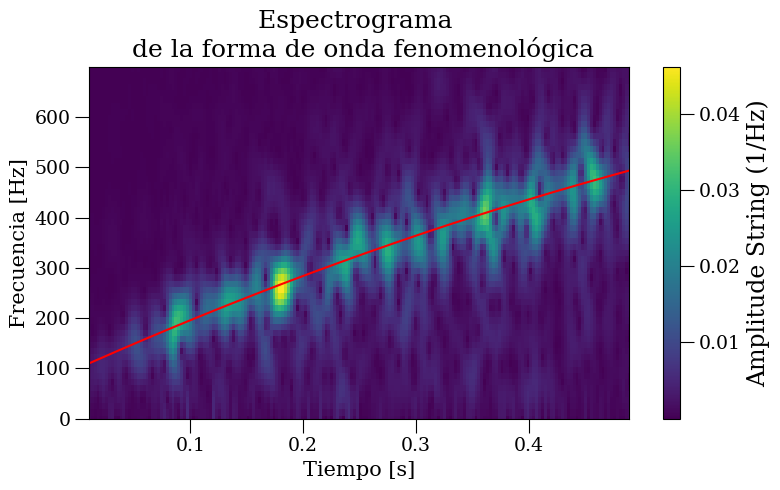

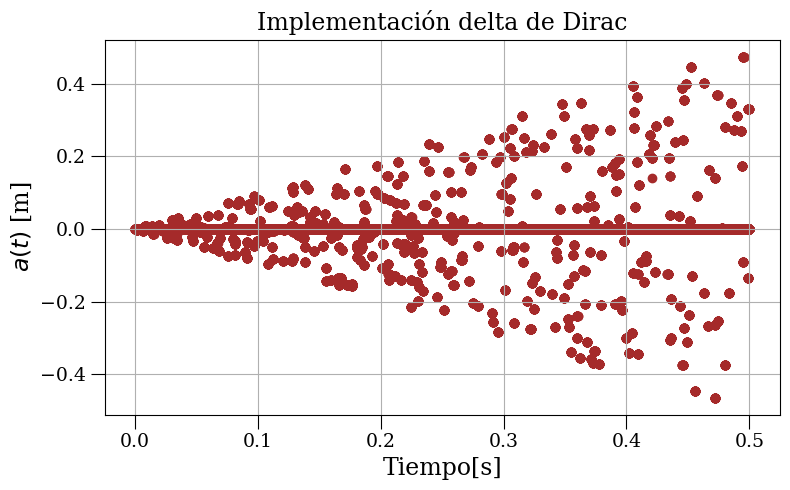

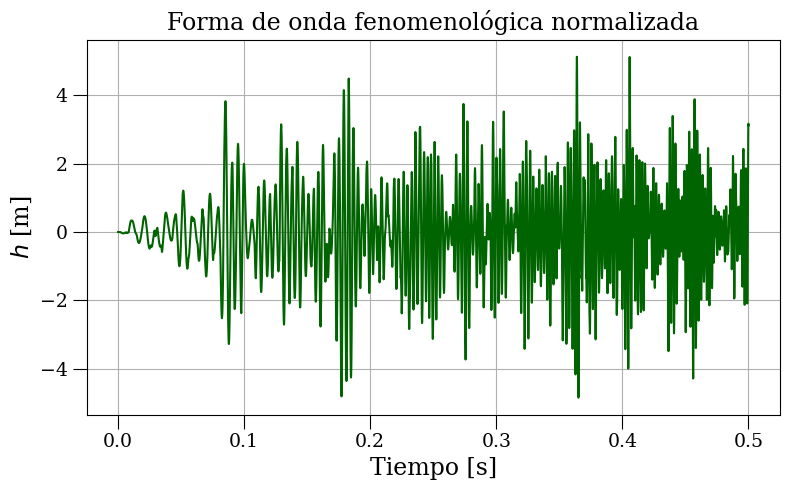

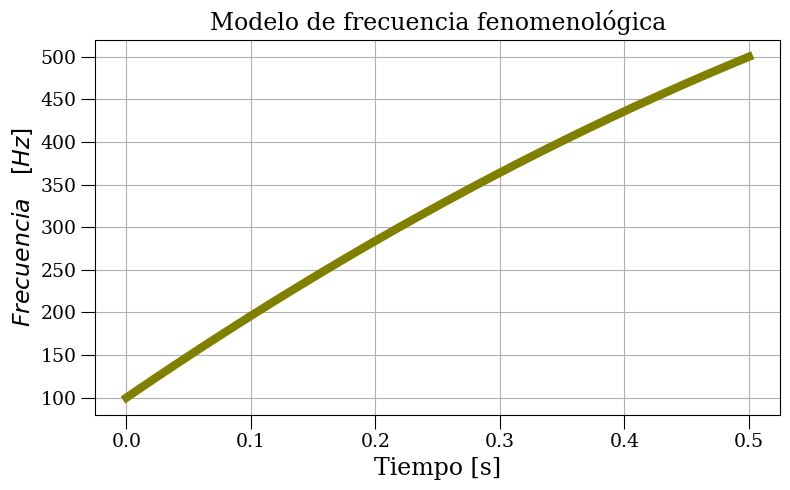

In [12]:
import os

# Create a folder to save all the plots
print(os.getcwd())
print(os.getcwd() + "\\Images\\")


path = os.getcwd() + "\\Images\\"  #"C:\\Users\\PC\\Desktop\\Tesis\\Fen_tiz\\Images\\"

try:
    os.mkdir(path)
    print("The directory: {0}",path,"Created")
except FileExistsError:
    print("The directory: {0}",path,"Already exist")

# ===============PLot a(t) implementation

plt.plot(t_n,a_n1,"ob")
# plt.title("Uniform Distribution of a_n (WF" + str(OG) + ")", fontsize=16)
plt.title("Distribución uniforme de $a_{n}$", fontsize=16)
plt.ylabel("$a_{n}$ [m]", fontsize=13)
plt.xlabel("$t_{n}$ [s]", fontsize=13)
#plt.xlim(-.5,1.5)
plt.ylim(-1,1)
plt.grid()
plt.savefig(path +"a_n("+ str(OG)+").png",dpi=400)
plt.show()

# ======================== Plot the waveforms
plt.figure()
#plt.plot(to,hpo,label='hplus')
plt.plot(t_sres,h_res,"black",label="h_Fen")
#plt.plot(t1res,h1res,"black",label="h_Fen")
#plt.plot(to,hco,label='hcross')
#plt.plot(t,hx_SG,label="hcrossSG")
# plt.title("Waveform strain", fontsize=16)
plt.title("Forma de onda fenomenológica", fontsize=16)
plt.xlabel('Tiempo [s]', fontsize=13)
plt.ylabel('$h$ [m]', fontsize=13)
#plt.xlim(0,.5)
plt.grid()
plt.legend()
plt.tight_layout()
plt.savefig(path + "WF.png",dpi=400)
plt.show()

# =========================== Plot Spectrogram
plt.figure()
plt.pcolormesh(txx, fxx, Sxx,shading="auto")
plt.plot(t_s,f,"r")
# plt.title("Spectrogram of the WF No." + str(OG),fontsize=18)
plt.title("Espectrograma \n de la forma de onda fenomenológica",fontsize=18)
cbar = plt.colorbar()
cbar.set_label('Amplitude String (1/Hz)')
plt.ylim([0,max(f) +200])
plt.ylabel('Frecuencia [Hz]',fontsize=15)
plt.xlabel('Tiempo [s]',fontsize=15)
plt.xlim(min(txx),max(txx))
plt.tight_layout()
plt.savefig(path + "Spec_WF_No"+ str(OG) + ".png",dpi=400)
plt.show()

# ========================= plot Delta's Dirac
plt.figure()
plt.scatter(t_s,a, color="brown")
plt.xlabel("Tiempo[s]")
plt.ylabel("$a(t)$ [m]")
# plt.title("Dirac's Delta implementation")
plt.title("Implementación delta de Dirac")
plt.grid()
plt.tight_layout()
plt.savefig(path + "Dirac_"+ str(OG) + ".png",dpi=400)
plt.show()
# ========================== Pheno Normalized strain

plt.plot(t_s,ht,color="darkgreen")
# plt.title("Phenomenological waveform Normalized")
plt.title("Forma de onda fenomenológica normalizada")
plt.ylabel('$h$ [m]')
plt.xlabel("Tiempo [s]")
plt.grid()
plt.tight_layout()
plt.savefig(path + "WFN.png")
plt.show()

# ===============PLot Frecuency Alone

plt.plot(t_s,f,color="olive",linewidth = 6)
# plt.title("Phenom. Model Frequency")
plt.title("Modelo de frecuencia fenomenológica")
plt.ylabel("$Frecuencia \quad [Hz]$")
plt.xlabel("Tiempo [s]")
#plt.xlim(-.5,1.5)
#plt.ylim(-1,1)
plt.grid()
plt.tight_layout()
plt.savefig(path +"Freq.png",dpi=400)
plt.show()



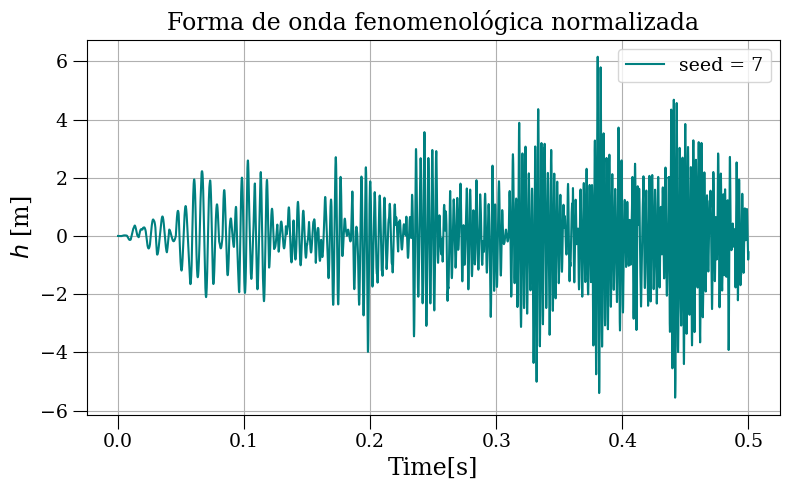

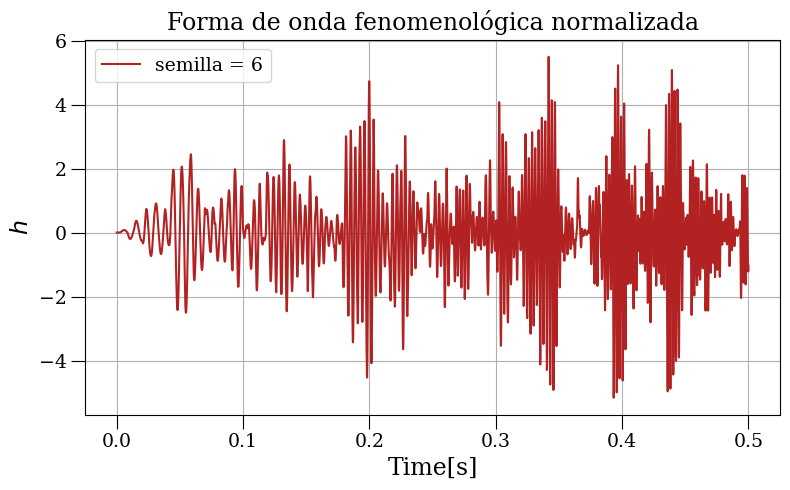

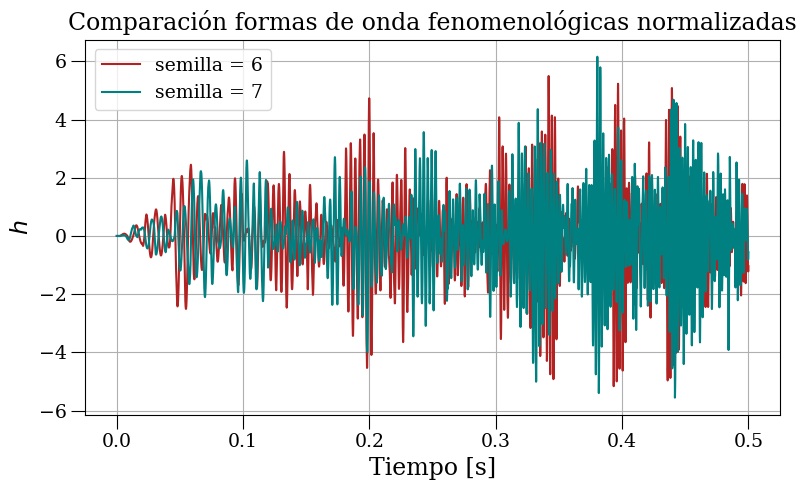

In [13]:
seed= 7 
rng = np.random.default_rng(seed = seed)
Fm,N,n,t_s,t_n,t_n1,f,w,Q,dt,t_ini,t_end,OG = cond(200000,0.0,0.5,100,700,1.25,200,10,3)

a,a_n17  = delta_imp()                  #Dirac Delta
h7 = model()                            #Waveform
t_sres7,h_res7 = sn_resample_wave(t_s,h,sample) #Resample to LIGO frequency

hrss_calc7   = sn_hrss_wave(t_s,h7,np.zeros(len(h7))) #hrss calculated from our WF
ht7 = h7 / hrss_calc7 #Scale on h(t) #WF Normalized


plt.plot(t_s,ht7,color="teal",label = "seed = 7")
# plt.title("Phenomenological waveform Normalized")
plt.title("Forma de onda fenomenológica normalizada")
plt.ylabel('$h$ [m]')
plt.xlabel("Time[s]")
plt.grid()
plt.legend()
plt.tight_layout()
plt.savefig(path + "WFN7.png")
plt.show()



seed= 6 
rng = np.random.default_rng(seed = seed)
Fm,N,n,t_s,t_n,t_n1,f,w,Q,dt,t_ini,t_end,OG = cond(200000,0.0,0.5,100,700,1.25,200,10,3)

a,a_n16  = delta_imp()                  #Dirac Delta
h6 = model()                            #Waveform
t_sres6,h_res6 = sn_resample_wave(t_s,h,sample) #Resample to LIGO frequency

hrss_calc6   = sn_hrss_wave(t_s,h6,np.zeros(len(h6))) #hrss calculated from our WF
ht6 = h6 / hrss_calc6 #Scale on h(t) #WF Normalized

plt.plot(t_s,ht6,color="firebrick",label = "semilla = 6")
# plt.title("Phenomenological waveform Normalized")
plt.title("Forma de onda fenomenológica normalizada")
plt.ylabel('$h$')
plt.xlabel("Time[s]")
plt.grid()
plt.legend()
plt.tight_layout()
plt.savefig(path + "WFN6.png")
plt.show()


plt.plot(t_s,ht6,color="firebrick",label = "semilla = 6")
plt.plot(t_s,ht7,color="teal",label = "semilla = 7")
# plt.title("Phenomenological waveform Normalized")
plt.title("Comparación formas de onda fenomenológicas normalizadas")
plt.ylabel('$h$')
plt.xlabel("Tiempo [s]")
plt.grid()
plt.legend()
plt.tight_layout()
plt.savefig(path + "WFNcomp.png")
plt.show()

### Comparison between GW150914 vs Phenomenological Waveform

C:\Users\PC\Desktop\Tesis\Fen_tiz
C:\Users\PC\Desktop\Tesis\Fen_tiz\LIGO_StrainData
The directory: {0} C:\Users\PC\Desktop\Tesis\Fen_tiz\LIGO_StrainData Already exist


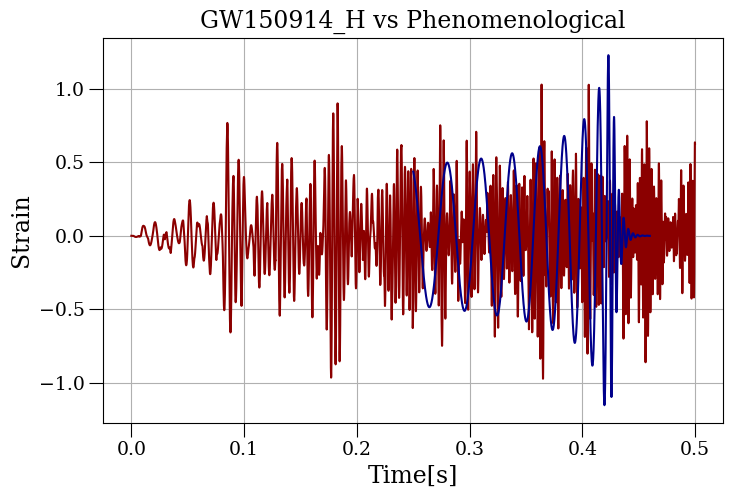

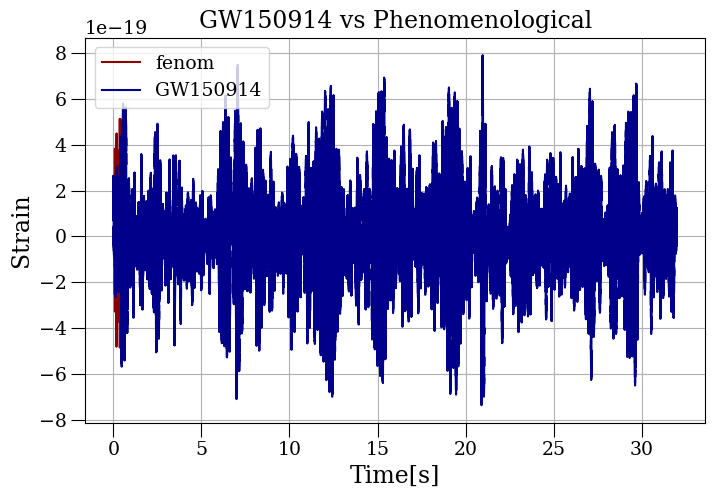

In [14]:
# Get back to the main path 
import os
mainpath = r"C:\Users\PC\Desktop\Tesis\Fen_tiz"
try:
    os.chdir(mainpath)
except FileNotFoundError:
    print("Directory: {0} does not exist".format(path))
except FileExistsError:
    print("The directory: {0}",path,"Already exist")
print(os.getcwd())  

# Define the new directory where is going to be stored the GW Strain
print(os.getcwd() + r"\LIGO_StrainData")

path = os.getcwd() + r"\LIGO_StrainData"  

try:
    os.mkdir(path)
    print("The directory: {0}",path,"Created")
except FileExistsError:
    print("The directory: {0}",path,"Already exist")


# Read the signal download of GWOSC data storage.    
dataGWH = pd.read_csv(r"LIGO_StrainData\fig2-unfiltered-waveform-H.txt", header = 0,delim_whitespace= True)
dataGWun = pd.read_csv(r"LIGO_StrainData\H-H1_LOSC_16_V2-1126259446-32.txt",header=3,delim_whitespace=True)
# GW_time = GW150914["time"] Desktop/Tesis/Fen_tiz/LIGO_StrainData/fig2-unfiltered-waveform-H.txt
# GW_strain = GW150914["strain"]
# print(dataGWH)
tGWH = dataGWH["#_time_(seconds)"]
sGWH = dataGWH["strain_*_1.e21"]

#Desktop/Tesis/Fen_tiz/LIGO_StrainData/H-H1_LOSC_16_V2-1126259446-32.txt

fm =16384
dt1 = 1/fm
t_GW = np.arange(0,32,dt1)
# print(dataGWun)
#tGWL = dataGWun["#_frequency_(Hz)"]
sGW = dataGWun["#strain"]


# print(len(t_GW))
# print(len(sGW))
# tGWL = np.asarray(tGWL) # Convert in to arrays
# sGWL = np.asarray(sGWL) # Convert in to arrays
sGW  = np.asarray(sGW)
tGWH = np.asarray(tGWH) # Convert in to arrays
sGWH = np.asarray(sGWH) # Convert in to arrays

plt.plot(t_s,ht/5,color = "darkred",label="fenom")
plt.plot(tGWH,sGWH, color="darkblue", label="GW150914_H")
plt.title("GW150914_H vs Phenomenological")
plt.ylabel("Strain")
plt.xlabel("Time[s]")
plt.grid()
plt.show()

# plot by hrss determinated
plt.plot(t_s,ht*1e-19,color = "darkred",label="fenom")
plt.plot(t_GW,sGW, color="darkblue",label= "GW150914")
plt.title("GW150914 vs Phenomenological")
plt.ylabel("Strain")
plt.xlabel("Time[s]")
plt.legend()
plt.grid()
plt.show()



In [16]:
# # =====================
# wnd="hamming"
# nfft=4*512
# nperseg=256
# noverlap=256-5

# fxxGW, txxGW, SxxGW = sg.spectrogram(sGW, sample, window=wnd, nfft=nfft, nperseg=nperseg, noverlap=noverlap, mode='magnitude')
# plt.figure()
# plt.pcolormesh(txxGW, fxxGW, SxxGW,shading="auto",vmin=1e-22, vmax=1e-23)
# #plt.plot(t_s,f,"r")
# plt.title("Spectrogram of the WF No." + str(OG),fontsize=18)
# cbar = plt.colorbar()
# cbar.set_label('Amplitude String (1/Hz)')
# plt.ylim([0,max(fxxGW)])
# plt.ylabel('Frequency [Hz]',fontsize=15)
# plt.xlabel('Time [s]',fontsize=15)
# plt.xlim(min(txxGW),max(txxGW))
# plt.tight_layout()
# #plt.savefig(path + "Spec_WF_No"+ str(OG) + ".png",dpi=400)
# plt.show()


## The evolution of the frequency in t_2 and why must be grather than the t_end 

In [17]:
# def plot_spectrogram(f,t,Sxx,t2,ax=None,**Kwargs):    
#     """ Función para plotear el espectrograma
#     """
#     plt.figure()
#     plt.pcolormesh(t, f, Sxx,shading="auto")
#     #plt.plot(t_s,f,"r")
#     plt.title("Spectrogram of the signal OG" + str(OG)+ str(t2),fontsize=18)
#     cbar = plt.colorbar()
#     cbar.set_label('Amplitude String (1/Hz)')
#     plt.ylim([-50,max(f) +100])
#     plt.ylabel('Frequency [Hz]',fontsize=15)
#     plt.xlabel('Time [s]',fontsize=15)
#     #plt.xlim(0,0.7)
#     plt.tight_layout()

#     #plt.savefig(path + "Spec_OG_"+ str(OG) + str(t2) +".png",dpi=400)
#     plt.show()


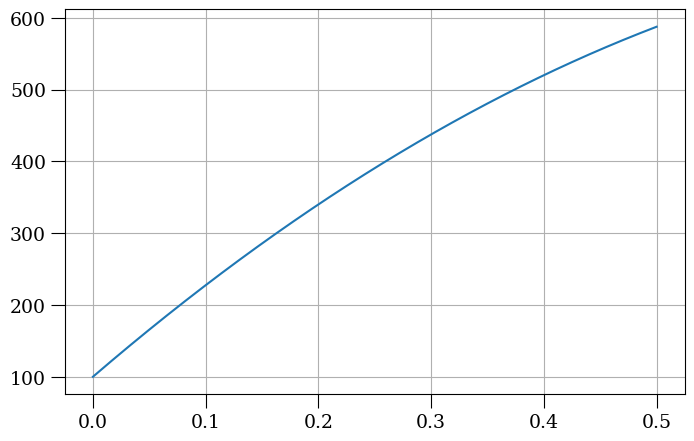

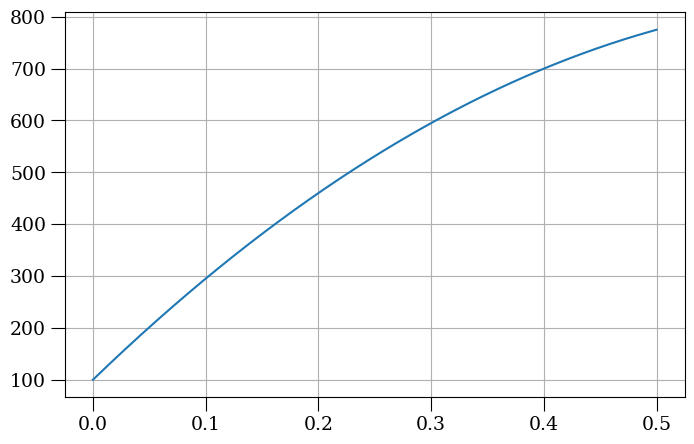

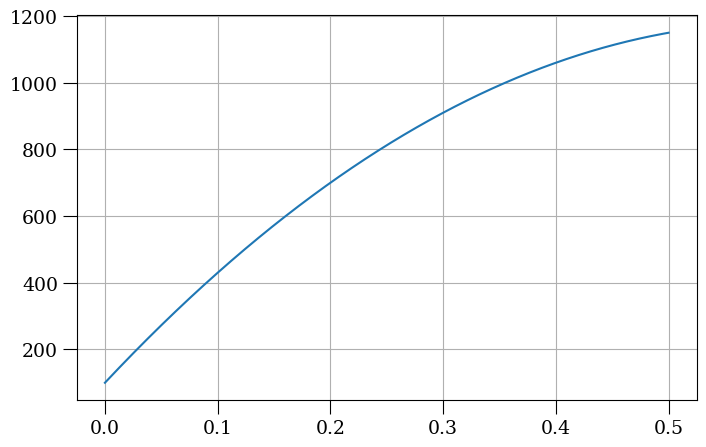

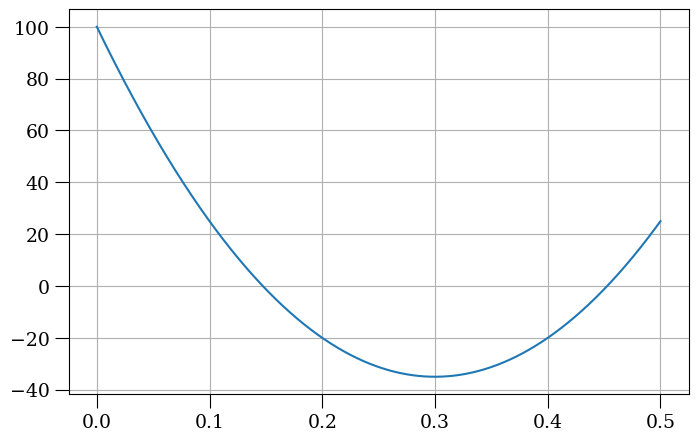

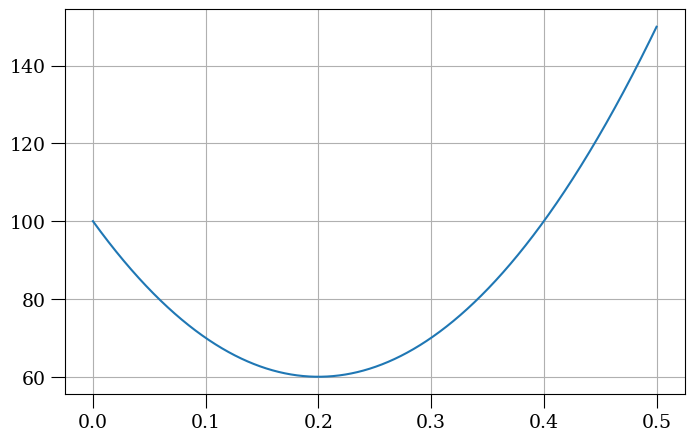

In [15]:
# Check the frequency

# As we see in the paper, t_2 should be great than t_{end} 

# Fm,N,n,t_s,t_n,t_n1,f1,w,Q,dt,t_ini,t_end,OG = cond(200000,0.0,0.5,100,700,1.25,200,10,8,3)
t2_1 = 0.9
t2_2 = 0.7
t2_3 = 0.6
t2_4 = 0.3
t2_5 = 0.2


Fm,N,n,t_s,t_n,t_n1,f1,w,Q,dt,t_ini,t_end,OG = cond(200000,0.0,0.5,100,700,t2_1,200,10,3)
plt.plot(t_s,f1)
plt.grid()
plt.show()

a,a_n1  = delta_imp()                  #Dirac Delta
h1 = model() 
fs1,ts1,Sxx1 = spectrogram(h1,Fm)

Fm,N,n,t_s,t_n,t_n1,f2,w,Q,dt,t_ini,t_end,OG = cond(200000,0.0,0.5,100,700,t2_2,200,10,3)
plt.plot(t_s,f2)
plt.grid()
plt.show()

a,a_n1  = delta_imp()                  #Dirac Delta
h2 = model() 
fs2,ts2,Sxx2 = spectrogram(h2,Fm)

Fm,N,n,t_s,t_n,t_n1,f3,w,Q,dt,t_ini,t_end,OG = cond(200000,0.0,0.5,100,700,t2_3,200,10,3)
plt.plot(t_s,f3)
plt.grid()
plt.show()

a,a_n1  = delta_imp()                  #Dirac Delta
h3 = model() 
fs3,ts3,Sxx3 = spectrogram(h3,Fm)

Fm,N,n,t_s,t_n,t_n1,f4,w,Q,dt,t_ini,t_end,OG = cond(200000,0.0,0.5,100,700,t2_4,200,10,3)
plt.plot(t_s,f4)
plt.grid()
plt.show()

a,a_n1  = delta_imp()                  #Dirac Delta
h4 = model() 
fs4,ts4,Sxx4 = spectrogram(h4,Fm)


Fm,N,n,t_s,t_n,t_n1,f5,w,Q,dt,t_ini,t_end,OG = cond(200000,0.0,0.5,100,700,t2_5,200,10,3)
plt.plot(t_s,f5)
plt.grid()
plt.show()

a,a_n1  = delta_imp()                  #Dirac Delta
h5 = model() 
fs5,ts5,Sxx5 = spectrogram(h5,Fm)



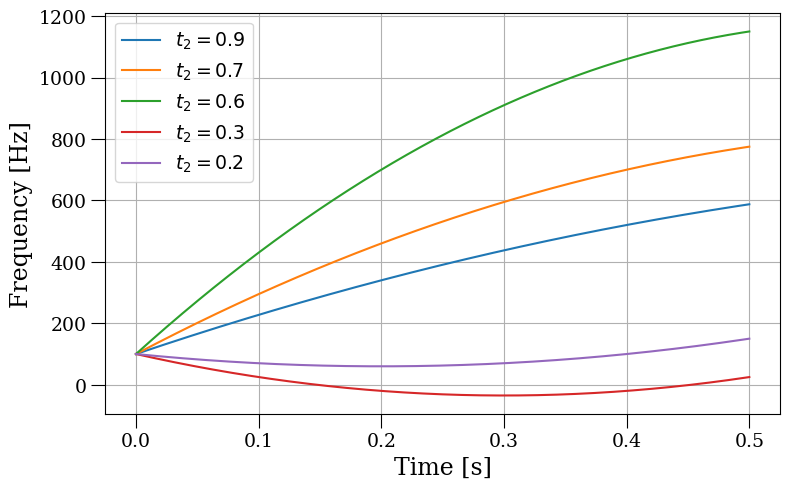

In [16]:
plt.figure()
plt.plot(t_s,f1, label="$t_{2} = 0.9$")
plt.plot(t_s,f2, label="$t_{2} = 0.7$")
plt.plot(t_s,f3, label="$t_{2} = 0.6$")
plt.plot(t_s,f4, label="$t_{2} = 0.3$")
plt.plot(t_s,f5, label="$t_{2} = 0.2$")
plt.xlabel("Time [s]")
plt.ylabel("Frequency [Hz]")
plt.grid()
plt.legend()
plt.tight_layout()

plt.savefig("T_2Graph.png",dpi=400)

plt.show()

<Figure size 800x500 with 0 Axes>

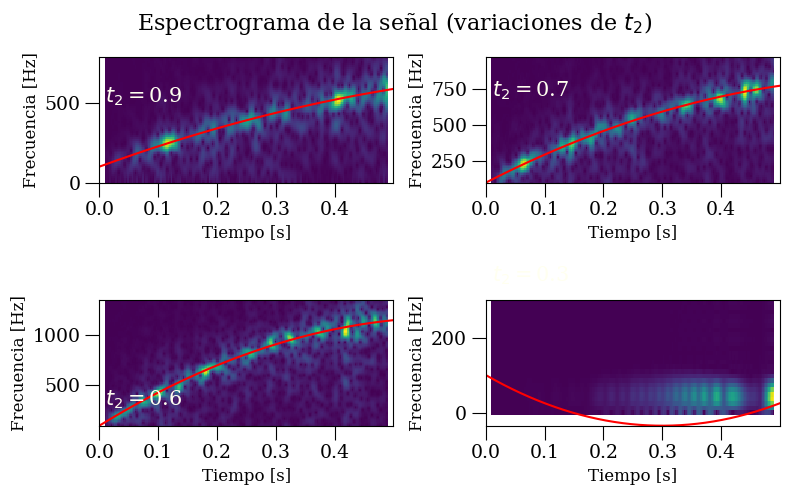

In [17]:
plt.figure()
fig,axs = plt.subplots(2,2,tight_layout = True)
# plt.suptitle("Spectrogram of the signal (variations of $t_{2}$)",fontsize=16)
plt.suptitle("Espectrograma de la señal (variaciones de $t_{2}$)",fontsize=16)
axs[0,0].pcolormesh(ts1, fs1, Sxx1,shading="auto")
axs[0,0].plot(t_s,f1,"r")
axs[0,0].set_ylim([0,max(f1) +200])
axs[0,0].set_ylabel('Frecuencia [Hz]',fontsize=12)
axs[0,0].set_xlabel('Tiempo [s]',fontsize=12)
axs[0,0].set_xlim([0,max(t_s)])
axs[0,0].text(0.01,500,"$t_{2} = $" + str(t2_1),{'color': 'ivory', 'fontsize': 15})

axs[0,1].pcolormesh(ts2, fs2, Sxx2,shading="auto")
axs[0,1].plot(t_s,f2,"r")
axs[0,1].set_ylim([min(f2),max(f2) +200])
axs[0,1].set_ylabel('Frecuencia [Hz]',fontsize=12)
axs[0,1].set_xlabel('Tiempo [s]',fontsize=12)
axs[0,1].set_xlim([0,max(t_s)])
axs[0,1].text(0.01,700,"$t_{2} = $" + str(t2_2),{'color': 'ivory', 'fontsize': 15})

axs[1,0].pcolormesh(ts3, fs3, Sxx3,shading="auto")
axs[1,0].plot(t_s,f3,"r")
axs[1,0].set_ylim([min(f3),max(f3) +200])
axs[1,0].set_ylabel('Frecuencia [Hz]',fontsize=12)
axs[1,0].set_xlabel('Tiempo [s]',fontsize=12)
axs[1,0].set_xlim([0,max(t_s) ])
axs[1,0].text(0.01,300,"$t_{2} = $" + str(t2_3),{'color': 'ivory', 'fontsize': 15})

axs[1,1].pcolormesh(ts4, fs4, Sxx4, shading="auto")
axs[1,1].plot(t_s,f4,"r")
axs[1,1].set_ylim([min(f4),max(f4) +200])
axs[1,1].set_ylabel('Frecuencia [Hz]',fontsize=12)
axs[1,1].set_xlabel('Tiempo [s]',fontsize=12)
axs[1,1].set_xlim([0,max(t_s) ])
axs[1,1].text(0.01,350,"$t_{2} = $" + str(t2_4),{'color': 'ivory', 'fontsize': 15})

plt.tight_layout()
plt.savefig(path + "Spec_WF_"+ str(OG)+ "changet2_" + str(t2_1) +".png",dpi=400)
plt.show()

## Sensitivity data (calculation and comparisioned)

In [18]:
# Read Ligo data and convert in a Df
# =====================================


data = pd.read_csv(r"C:\Users\PC\Desktop\Tesis\Fen_tiz\LIGO_sensdata\O3b-L1.txt",header = None,delim_whitespace=True)
data1 = pd.read_csv(r"C:\Users\PC\Desktop\Tesis\Fen_tiz\LIGO_sensdata\O3b-H1.txt",header = None,delim_whitespace=True)
# #data2 = pd.read_csv("L1_03.txt",header = None,delim_whitespace=True)

L1_02t = data[0]
H1_02t = data1[0]
# #L1_03t = data2[0]

L1_02f = data[1]
H1_02f = data1[1]
# #L1_03f = data2[1]

L1_02f = np.asarray(L1_02f)
L1_02t = np.asarray(L1_02t)

H1_02f = np.asarray(H1_02f)
H1_02t = np.asarray(H1_02t)


In [19]:
def Fourier_transform(t1,h1):
    from scipy import fftpack
    """
    t1: The time of the original signal
    h1: The original signal h(t)
    # => Return
    H: h(f)
    fr: The frecuency get of h
    """
    dt = t1[1] - t1[0]

    #Fourier Transform
    H = dt*fftpack.fft(h1)
    fr = fftpack.fftfreq(len(t1),dt)

    #Shift Data in normal order
    fr = fftpack.fftshift(fr)
    H = dt*fftpack.fftshift(H)

    # use only real data from m/2+1 (freq>0) to m-1
    # double- to one-sided
    m = len(fr)
    fr = fr[int(m/2)+1:m-1]
    H = 2*H[int(m/2)+1:m-1] 
    return fr,H

def hchar(fr,H):
    """ Characteristic Strain of the Waveform
    fr:Frecuency of h
    H: h(f)
    # => Return
    hchar: Characteristic Strain h
    fchar: Characteristic Frequency
    """
    #Strain característico
    hchar = fr * H
    hchar = abs(hchar)
    print(hchar)
    fchar = fr
    return hchar,fchar
    
def medfilt(hchar,n):    
    """ Median filter to a output array
    hchar: Characteristic Strain
    n: The size of the median filter window
    """
    #Smooth
    hchar = sg.medfilt(abs(hchar),n)
    print(hchar)
    return hchar
    
def root_psd(hchar,fchar):
    """sd
    """    
    #SROOT PSD SIGNAL
    Root_psd_wave =  hchar * fchar**(-0.5)
    return Root_psd_wave

def peak(fchar,Spect_wave):
    lem = np.argmax(Spect_wave)
    fchar_peak = fchar[lem]
    root_peak = Spect_wave[lem]

    return fchar_peak,root_peak
# ============== hchar 


In [20]:
# =============== Root_PSD GW150914

sSGWH = sGWH*1e-21
GWHfchar, GWHhchar_wave = sn_hchar_wave(tGWH,sSGWH)
# Smoothen the characteristic strains
GWHhchar_wave_h_med = sn_medfilt_wave(GWHhchar_wave,1)
# To be able to plot characteristic strain together with detector noise, 
# the characteristic strain need to be multiplied by -1/2 power (check units)
spect_wave_hGWH = GWHhchar_wave_h_med * GWHfchar**(-0.5)
# =============== Root_PSD GW150914

# sSGWH = sGWH*1e-21
GWfchar, GWhchar_wave = sn_hchar_wave(t_GW,sGW)
# Smoothen the characteristic strains
GWhchar_wave_h_med = sn_medfilt_wave(GWhchar_wave,1)
# To be able to plot characteristic strain together with detector noise, 
# the characteristic strain need to be multiplied by -1/2 power (check units)
spect_wave_hGW = GWhchar_wave_h_med * GWfchar**(-0.5)
# =============== Root_PSD in normalized multiply by hrss selected
hSt = ht*1e-22
fenchar, fhchar_wave = sn_hchar_wave(t_s,hSt)
# Smoothen the characteristic strains
fehchar_wave_h_med = sn_medfilt_wave(fhchar_wave,5)
spect_wave_hN = fehchar_wave_h_med * fenchar**(-0.5)
# =============== Root_PSD h multiply by hrss selected
hS_res = h_res*1e-12
Phfchar, Phhchar_wave = sn_hchar_wave(t_sres,hS_res)
# Smoothen the characteristic strains
Phhchar_wave_h_med = sn_medfilt_wave(Phhchar_wave,5)
spect_wave_hPh = Phhchar_wave_h_med * Phfchar**(-0.5)

hrss1 = 1e-21
hrss2 = 1e-22
hrss3 = 1e-25
hrss4 = 1e-26

hSt1 = ht * hrss1
hSt2 = ht * hrss2
hSt3 = ht * hrss3
hSt4 = ht * hrss4
# ============== Ph1-hrss1

Ph1fchar, Ph1hchar_wave = sn_hchar_wave(t_s,hSt1)
Ph1hchar_wave_h_med = sn_medfilt_wave(Ph1hchar_wave,5)
spect_wave_hPh1 = Ph1hchar_wave_h_med * Ph1fchar**(-0.5)

# ============== Ph2-hrss2

Ph2fchar, Ph2hchar_wave = sn_hchar_wave(t_s,hSt2)
Ph2hchar_wave_h_med = sn_medfilt_wave(Ph2hchar_wave,5)
spect_wave_hPh2 = Ph2hchar_wave_h_med * Ph2fchar**(-0.5)


In [21]:
# Calculte hrss
hrssGW = sn_hrss_wave(tGWH,sSGWH,np.zeros(len(sSGWH)))
hrss_norm = sn_hrss_wave(t_s,hSt,np.zeros(len(hSt)))
hrss_PH = sn_hrss_wave(t_sres,hS_res,np.zeros(len(hS_res)))


print(hrssGW)
print(hrss_norm)
print(hrss_PH)

1.9688481707650327e-22
9.999999999999971e-23
1.9470085448234796e-13


### SNR calculation: $snr^{2} = 4 \int_{}^{} \frac{|h(f)|^2}{S_h(f)} \,df$

In [22]:
SNRPh02L1 = sn_snr_wave(t_s,hSt,L1_02t,L1_02f)
SNRPh02H1 = sn_snr_wave(t_s,hSt,H1_02t,H1_02f)


SNRPH1 = sn_snr_wave(t_s,ht,Ph1fchar,spect_wave_hPh1)
SNRPH2 = sn_snr_wave(t_s,ht,Ph2fchar,spect_wave_hPh2)

print(SNRPh02H1)
print(SNRPh02L1)
print(SNRPH1)
print(SNRPH2)



print("SNR 03L1:",SNRPh02L1)
print("SNR 031:",SNRPh02H1)

27.330273975233453
28.058133446692676
4.0378990075171926e+21
4.037899007517139e+22
SNR 03L1: 28.058133446692676
SNR 031: 27.330273975233453


### Sensitivity Curve

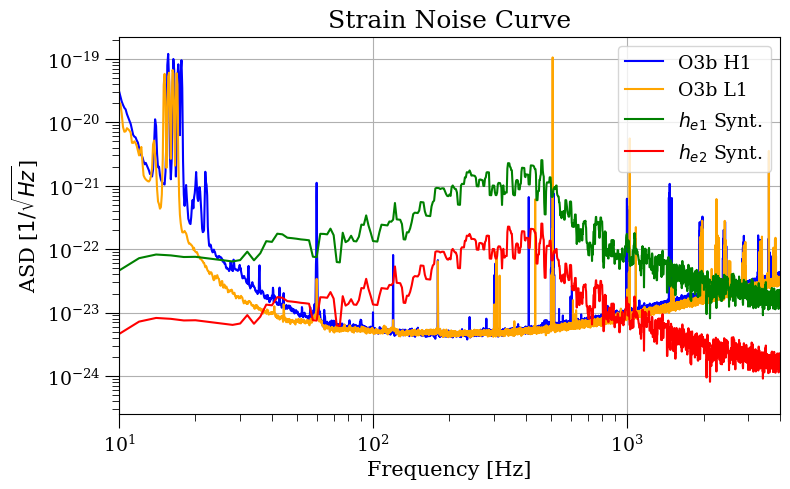

In [23]:
 plt.title("Strain Noise Curve", fontsize=18)
#plt.title("Curvas de sensibilidad", fontsize=18)
plt.loglog(H1_02t,H1_02f,color="blue",label="O3b H1")
plt.loglog(L1_02t,L1_02f,color="Orange",label="O3b L1")
# plt.plot(GWHfchar, spect_wave_hGWH,label='GW150914H',color="darkgreen")
# plt.plot(GWfchar, spect_wave_hGW,label='GW150914H-',color="darkorange")
#plt.loglog(L1_03t,L1_03f,color="green",label="O3_L1")
#plt.plot(fchar, spect_wave_hc,label='hcross SineGaussian',color="red")
#plt.plot(fenchar, spect_wave_hN,label='h_norm Fenom',color="purple")
# plt.plot(Ph1fchar, spect_wave_hPh1,label='$h_{Norm}*h_{rss1}$ Fenom.',color="green")
# plt.plot(Ph2fchar, spect_wave_hPh2,label='$h_{Norm}*h_{rss2}$ Fenom.',color="red")
plt.plot(Ph1fchar, spect_wave_hPh1,label='$h_{e1}$ Synt.',color="green")
plt.plot(Ph2fchar, spect_wave_hPh2,label='$h_{e2}$ Synt.',color="red")
# plt.plot(fchar,Spect_wave, label='$h_{Fenom}$',color="purple")
# plt.plot(fchar,Spect_waveh1, label='$h_{hrss1}$',color="brown")
# plt.plot(fchar,Spect_waveh2, label='$h_{hrss2}$',color="green")
# plt.plot(fchar,Spect_waveh3, label='$h_{hrss3}$',color="red")
# plt.plot(fpeak,root_peak, marker="*",label="$f_{peak},h_{rss}$ =" + str(format(hrss,".2e")))
# plt.plot(fpeak,root_peak1, marker="*",label="$f_{peak}, h_{rss1}$ =" + str(format(hrss1,".2e")))
# plt.plot(fpeak,root_peak2, marker="*",label="$f_{peak}, h_{rss2}$=" + str(format(hrss2,".2e")))
# plt.plot(fpeak,root_peak3, marker="*",label="$f_{peak}, h_{rss3}$ =" + str(format(hrss3,".2e")))
plt.xlabel("Frequency [Hz]",fontsize=15)
plt.ylabel("ASD [$1/\sqrt{Hz}$]",fontsize=15)
plt.xlim(10,4.0e3)
#plt.ylim([1.0e-28,7.0e-21])
plt.legend()
plt.tight_layout()
plt.grid()
plt.savefig(path + "WF"+str(OG)+"Noise.png",dpi=200)
plt.show()

# Comparison solo figure GW150914 vs Phenomenological

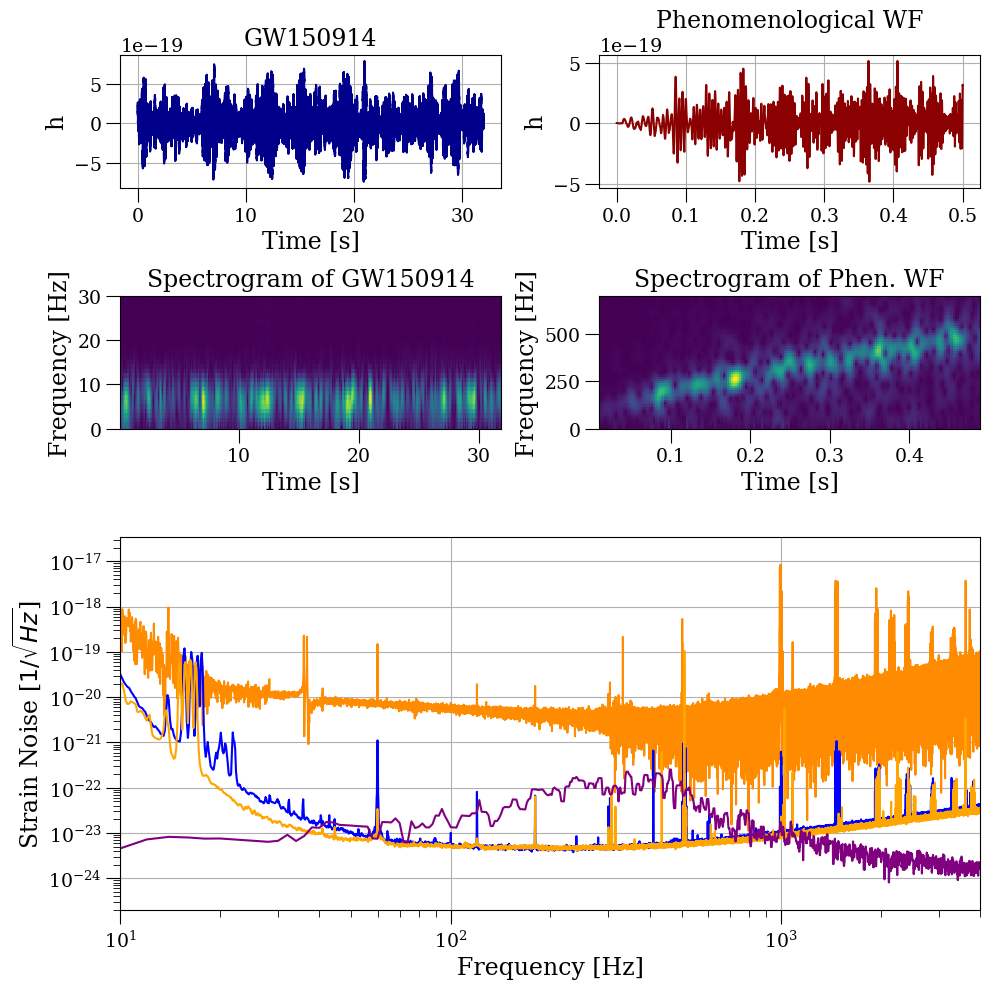

In [24]:
import matplotlib.gridspec as gridspec

fxxGW, txxGW, SxxGW = sg.spectrogram(sGW, fm, window=wnd, nfft=nfft, nperseg=nperseg, noverlap=noverlap, mode='magnitude')

# ax.text(left, bottom, 'left top',
#         horizontalalignment='left',
#         verticalalignment='top',
#         transform=ax.transAxes)



plt.close('all')
fig = plt.figure(tight_layout= True,figsize = (10,10))
gs1 = gridspec.GridSpec(4, 2)
ax1 = fig.add_subplot(gs1[0,0])#plt.plot(t_GW,sGW, color="darkblue",label= "GW150914")
ax1.plot(t_GW,sGW, color="darkblue",label= "GW150914")
ax1.set_xlabel("Time [s]")
ax1.set_ylabel("h")
ax1.set_title("GW150914")
ax1.grid()
ax1.autoscale()
ax2 = fig.add_subplot(gs1[0,1])
ax2.plot(t_s,ht*1e-19,color = "darkred",label="fenom")
ax2.set_xlabel("Time [s]")
ax2.set_ylabel("h")
ax2.set_title("Phenomenological WF")
ax2.grid()
ax3 = fig.add_subplot(gs1[1,1])
ax3.pcolormesh(txx, fxx, Sxx,shading="auto")
ax3.autoscale()
ax3.set_xlim(min(txx),max(txx))
ax3.set_ylim(0,max(f) +200)
ax3.set_xlabel("Time [s]")
ax3.set_ylabel("Frequency [Hz]")
ax3.set_title("Spectrogram of Phen. WF")
ax4 = fig.add_subplot(gs1[1,0])
ax4.pcolormesh(txxGW, fxxGW, SxxGW,shading="auto")
ax4.set_xlim(min(txxGW),max(txxGW))
ax4.set_ylim(0,30)
ax4.set_xlabel("Time [s]")
ax4.set_ylabel("Frequency [Hz]")
ax4.set_title("Spectrogram of GW150914")
ax5 = fig.add_subplot(gs1[2:,:])
ax5.plot(GWfchar, spect_wave_hGW,label='GW150914H-',color="darkorange")
ax5.loglog(H1_02t,H1_02f,color="blue",label="O3b H1")
ax5.loglog(L1_02t,L1_02f,color="Orange",label="O3b L1")
ax5.plot(fenchar, spect_wave_hN,label='h_e1 Synt',color="purple")
ax5.set_xlim(10,4.0e3)
ax5.set_xlabel("Frequency [Hz]")
ax5.set_ylabel("Strain Noise [$1/\sqrt{Hz}$]")
plt.grid()
#ax5.set_ylim(1.0e-25,1.0e-17)
#plt.tight_layout()
plt.show()




251 256


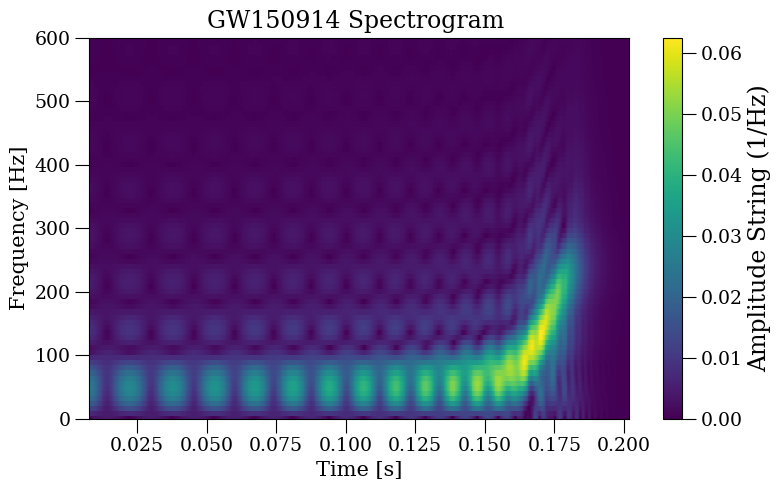

In [25]:
wnd="hamming"
nfft=4*512
nperseg=256
noverlap=256-5


print(noverlap,nperseg)
fxxGWH,txxGWH,SxxGWH = sg.spectrogram(sGWH,16386,nfft=nfft, nperseg=nperseg, noverlap=noverlap, mode='magnitude')

plt.figure()
plt.pcolormesh(txxGWH, fxxGWH, SxxGWH,shading="auto")
plt.title("GW150914 Spectrogram ")
cbar = plt.colorbar()
cbar.set_label('Amplitude String (1/Hz)')
plt.ylim([0,6e2])
plt.ylabel('Frequency [Hz]',fontsize=15)
plt.xlabel('Time [s]',fontsize=15)
plt.xlim(min(txxGWH),max(txxGWH))
plt.tight_layout()
plt.show()


In [26]:
wnd="hamming"
nfft=4*4096
nperseg=4096
noverlap=4096-512

fxx, txx, Sxx = sg.spectrogram(hsc, Fm, window=wnd, nfft=nfft, nperseg=nperseg, noverlap=noverlap, mode='magnitude')

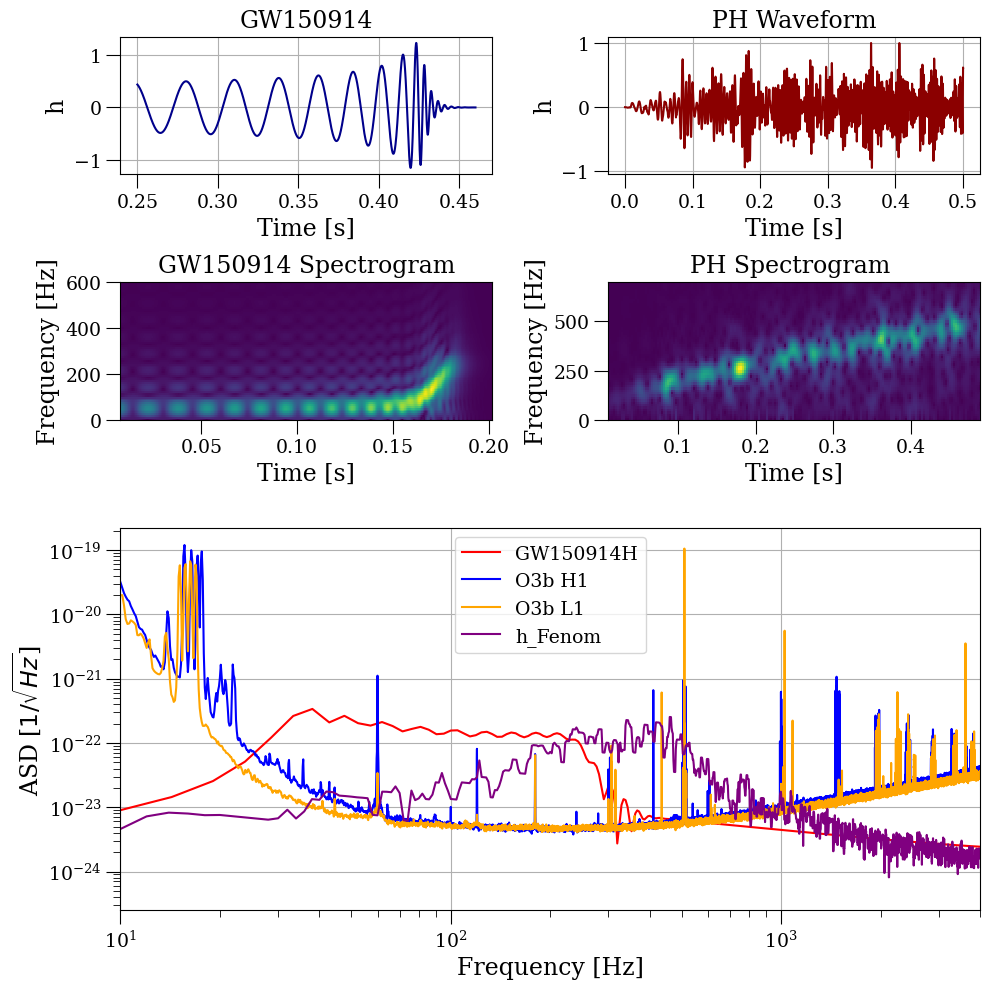

C:\Users\PC\Desktop\Tesis\Fen_tiz


In [27]:
sSGWH = sGWH*1e-21
GWHfchar, GWHhchar_wave = sn_hchar_wave(tGWH,sSGWH)
# Smoothen the characteristic strains
GWHhchar_wave_h_med = sn_medfilt_wave(GWHhchar_wave,1)
# To be able to plot characteristic strain together with detector noise, 
# the characteristic strain need to be multiplied by -1/2 power (check units)
spect_wave_hGWH = GWHhchar_wave_h_med * GWHfchar**(-0.5)


hSt = ht*1e-22
fenchar, fhchar_wave = sn_hchar_wave(t_s,hSt)
# Smoothen the characteristic strains
fehchar_wave_h_med = sn_medfilt_wave(fhchar_wave,5)
spect_wave_hN = fehchar_wave_h_med * fenchar**(-0.5)

plt.close('all')
fig = plt.figure(tight_layout= True,figsize = (10,10))
gs1 = gridspec.GridSpec(4, 2)
ax1 = fig.add_subplot(gs1[0,0])#plt.plot(t_GW,sGW, color="darkblue",label= "GW150914")
ax1.plot(tGWH,sGWH, color="darkblue",label= "GW150914")
ax1.set_xlabel("Time [s]")
ax1.set_ylabel("h")
ax1.set_title("GW150914")
ax1.grid()
ax1.autoscale()

ax2 = fig.add_subplot(gs1[0,1])
ax2.plot(t_s,h,color = "darkred",label="fenom")
ax2.set_xlabel("Time [s]")
ax2.set_ylabel("h")
ax2.set_title("PH Waveform")
ax2.grid()

ax3 = fig.add_subplot(gs1[1,1])
ax3.pcolormesh(txx, fxx, Sxx,shading="auto")
ax3.autoscale()
ax3.set_xlim(min(txx),max(txx))
ax3.set_ylim(0,max(f) +200)
ax3.set_xlabel("Time [s]")
ax3.set_ylabel("Frequency [Hz]")
ax3.set_title("PH Spectrogram ")

ax4 = fig.add_subplot(gs1[1,0])
ax4.pcolormesh(txxGWH, fxxGWH, SxxGWH,shading="auto")
#ax4.plot(txxGWH,fxxGWH,color="red")
ax4.set_xlim(min(txxGWH),max(txxGWH))
ax4.set_ylim(0,600)
ax4.set_xlabel("Time [s]")
ax4.set_ylabel("Frequency [Hz]")
ax4.set_title("GW150914 Spectrogram")

ax5 = fig.add_subplot(gs1[2:,:])
ax5.plot(GWHfchar, spect_wave_hGWH,label='GW150914H',color="red")
ax5.loglog(H1_02t,H1_02f,color="blue",label="O3b H1")
ax5.loglog(L1_02t,L1_02f,color="Orange",label="O3b L1")
ax5.plot(fenchar, spect_wave_hN,label='h_Fenom',color="purple")
ax5.set_xlim(10,4.0e3)
ax5.set_xlabel("Frequency [Hz]")
ax5.set_ylabel("ASD [$1/\sqrt{Hz}$]")
ax5.legend
plt.grid()
plt.legend()
plt.savefig("Comp_GW.png",dpi=400)
plt.show()
print(mainpath)

## Comparison Multi-Sim vs Phenomenological

In [ ]:
# #Andersen signal
# print(os.getcwd())
# # Desktop/Tesis/Fen_tiz/LIGO_StrainData/gw_s15nr.dat
# S_ander = np.loadtxt("LIGO_StrainData/gw_s15nr.dat")
# Sander = list()
# for i in range(0,654):
#     Sander.extend(S_ander[i])

# Sander = np.asarray(Sander)
# # print(Sander)
# Sander
# # La duración de la ventana de tiempo es de .31 s.
# t_endA = .31

# fmA = 16386
# # dtA = 1/fmA
# # t_san = np.arange(t_ini,t_endA,dtA)
# t_san = np.linspace(t_ini,t_endA,len(Sander))
# # dt1 = t_san[1] - t_san[0]
# # fm1 = 1/dt1

# plt.figure()
# plt.title("Anderser SN15r")
# plt.plot(t_san,Sander,color="green")
# plt.grid()
# plt.tight_layout()
# plt.show()

# # ==================== Spectrogram
# # wnd="hamming"
# # nfft=4*1026
# # nperseg=1026
# # noverlap=1026-100


# wnd="hamming"
# nfft=4*128
# nperseg=64
# noverlap=64-5
# fxxsan,txxsan,Sxxsan = sg.spectrogram(Sander*1e-22,fmA,nfft=nfft, nperseg=nperseg, noverlap=noverlap, mode='magnitude')

# # print(len(txxGWH), len(fxxGWH), len(SxxGWH))
# # print(len(txxsan), len(fxxsan), len(Sxxsan))
# # print(txxsan)
# plt.figure()
# plt.pcolormesh(txxsan, fxxsan, Sxxsan,shading="auto")
# plt.title("Andresen Spectrogram ")
# cbar = plt.colorbar()
# cbar.set_label('Amplitude String (1/Hz)')
# plt.ylim([0,2e3])
# plt.ylabel('Frequency [Hz]',fontsize=15)
# plt.xlabel('Time [s]',fontsize=15)
# plt.xlim(min(txxsan),max(txxsan))
# plt.tight_layout()
# plt.show()



In [35]:
seed= 8 
rng = np.random.default_rng(seed = seed)
Fm,N,n,t_s,t_n,t_n1,f,w,Q,dt,t_ini,t_end,OG = cond(200000,0.0,0.31,500,1500,1.25,200,10,3)
a,a_n1  = delta_imp()                  #Dirac Delta
h = model()                            #Waveform
t_sres,h_res = sn_resample_wave(t_s,h,sample) #Resample to LIGO frequency

In [36]:
wnd="hamming"
nfft=4*512
nperseg=256
noverlap=256-5
# Default resampling frequency
fs = 16384
fxx,txx,Sxx = sg.spectrogram(h_res,fs,nfft=nfft, nperseg=nperseg, noverlap=noverlap, mode='magnitude')

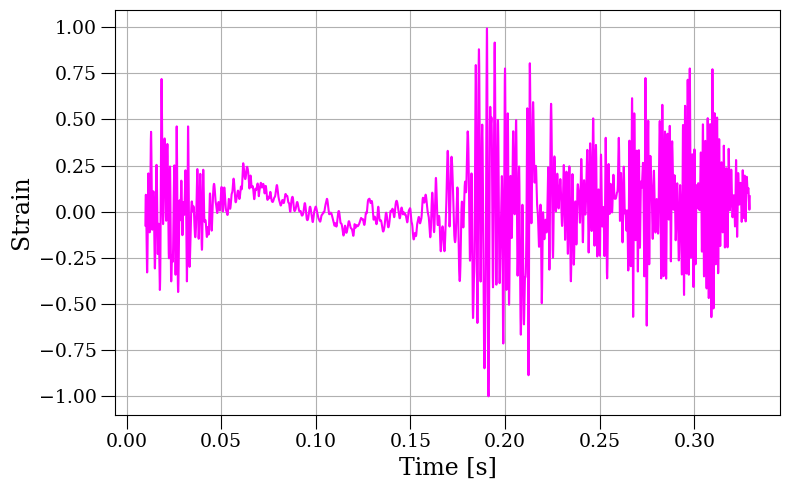

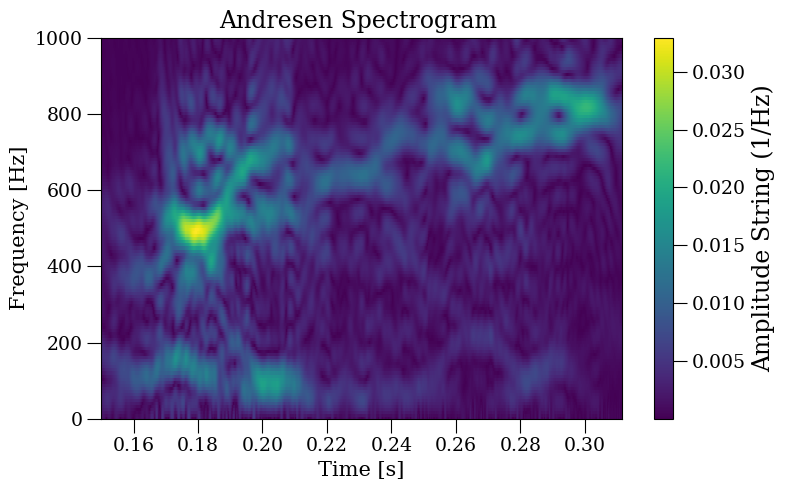

In [37]:
# Default distance, 10kpc in m
D = D10kpc 


import numpy as np

A = np.loadtxt("LIGO_StrainData/gw_s15nr.dat")
to = A[:,0]

# Create quadrupole moment array for the before processing
# The quadrupole is given at the source in cm, so it needs to be brought to the distance of 10kpc
qijo = np.zeros((len(to),3,3),dtype=float)

qijo[:,0,0] = A[:,1] * cm2kpc / 10.0 # convert cm to 10 kpc
qijo[:,1,1] = A[:,2] * cm2kpc / 10.0
qijo[:,2,2] = A[:,3] * cm2kpc / 10.0
qijo[:,0,1] = A[:,4] * cm2kpc / 10.0
qijo[:,0,2] = A[:,5] * cm2kpc / 10.0
qijo[:,1,2] = A[:,6] * cm2kpc / 10.0
qijo[:,2,1] = qijo[:,1,2]
qijo[:,2,0] = qijo[:,0,2]
qijo[:,1,0] = qijo[:,0,1]


# Create waveform at the equator with original data
(phi_eq, theta_eq) = (0.0, np.pi/2.0) # Equator
#(phi_eq, theta_eq) = (0.0, 0.0) # Pole
hpo, hco = sn_create_waveform(qijo,phi_eq,theta_eq) 

# Resample to 16384
t, hc  = sn_resample_wave(to, hco, fs)
t, hp  = sn_resample_wave(to, hpo, fs)

hp = hp /max(abs(hp))

# ============= PLot the waveform
plt.figure()
plt.plot(t,hp,color = "magenta")
# plt.plot(to,hpo*D10kpc*100,label='hplus')
# plt.plot(to,hco*D10kpc*100,label='hcross',alpha=0.5)
# plt.title("{0:s}".format(name))
plt.xlabel('Time [s]')
plt.ylabel('Strain')
plt.grid()
# plt.legend()
plt.tight_layout()
plt.show()
# =========== Spectrogram Andersen
wnd="hamming"
nfft=4*512
nperseg=256
noverlap=256-5
fxxsan,txxsan,Sxxsan = sg.spectrogram(hp,fs,nfft=nfft, nperseg=nperseg, noverlap=noverlap, mode='magnitude')

plt.figure()
plt.pcolormesh(txxsan, fxxsan, Sxxsan,shading="auto")
plt.title("Andresen Spectrogram ")
cbar = plt.colorbar()
cbar.set_label('Amplitude String (1/Hz)')
plt.ylim([0,1000])
plt.ylabel('Frequency [Hz]',fontsize=15)
plt.xlabel('Time [s]',fontsize=15)
plt.xlim(.15,max(txxsan))
plt.tight_layout()
plt.show()
# Determinate Hrss 
Andfchar, Andhchar_wave = sn_hchar_wave(t,hc)
# Smoothen the characteristic strains
Andhchar_wave_h_med = sn_medfilt_wave(Andhchar_wave,5)
# To be able to plot characteristic strain together with detector noise, 
# the characteristic strain need to be multiplied by -1/2 power (check units)
spect_wave_hAnd = Andhchar_wave_h_med * Andfchar**(-0.5)

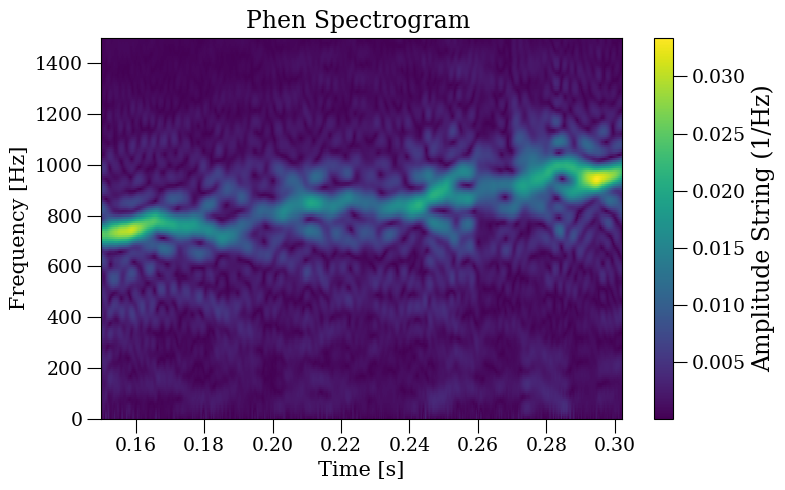

In [38]:
plt.figure()
plt.pcolormesh(txx, fxx, Sxx,shading="auto")
plt.title("Phen Spectrogram ")
cbar = plt.colorbar()
cbar.set_label('Amplitude String (1/Hz)')
plt.ylim([0,1500])
plt.ylabel('Frequency [Hz]',fontsize=15)
plt.xlabel('Time [s]',fontsize=15)
plt.xlim(.15,max(txx))
plt.tight_layout()
plt.show()


In [39]:
hSt8 = h_res*1e-22
Ph8fchar, Ph8hchar_wave = sn_hchar_wave(t_sres,hSt8)
Ph8hchar_wave_h_med = sn_medfilt_wave(Ph8hchar_wave,5)
spect_wave_hPh8 = Ph8hchar_wave_h_med * Ph8fchar**(-0.5)

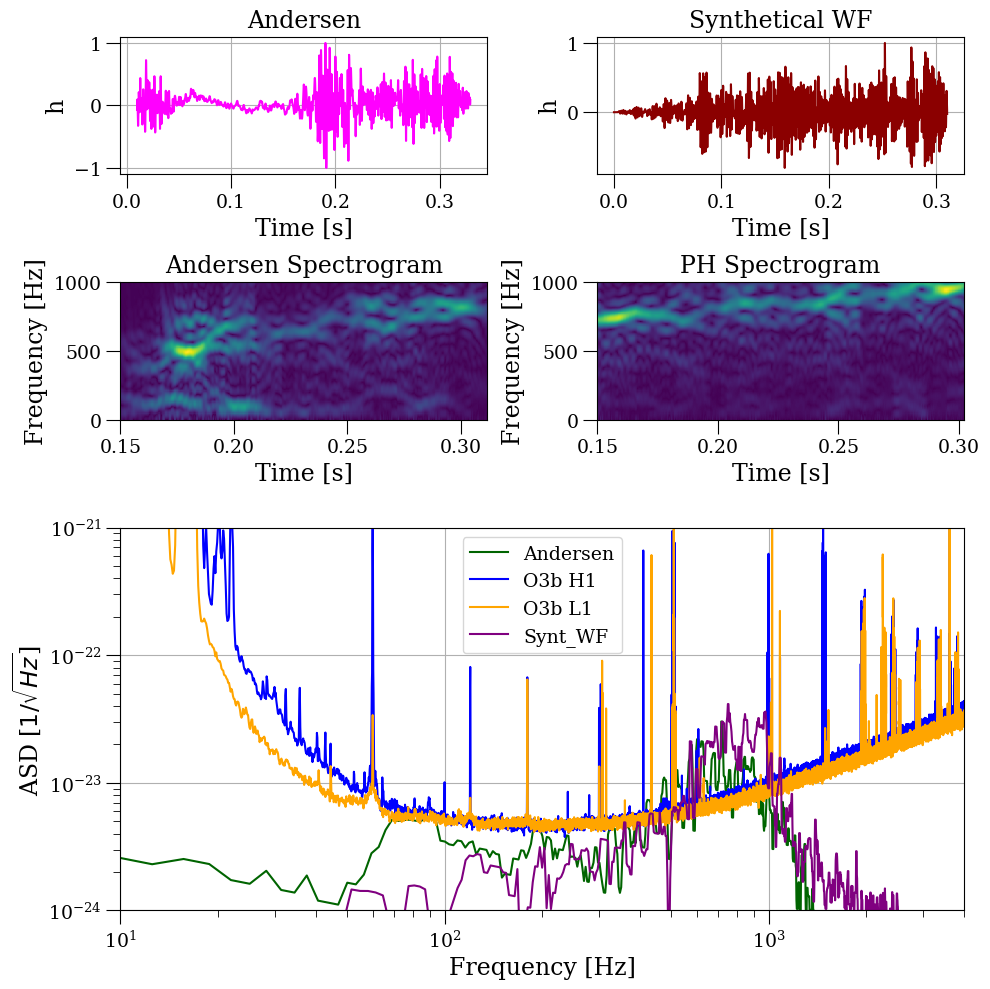

In [41]:
plt.close('all')
fig = plt.figure(tight_layout= True,figsize = (10,10))
gs1 = gridspec.GridSpec(4, 2)
ax1 = fig.add_subplot(gs1[0,0])#plt.plot(t_GW,sGW, color="darkblue",label= "GW150914")
plt.plot(t,hp,color = "magenta")
ax1.set_xlabel("Time [s]")
ax1.set_ylabel("h")
ax1.set_title("Andersen")
ax1.grid()
ax1.autoscale()

ax2 = fig.add_subplot(gs1[0,1])
ax2.plot(t_sres,h_res,color = "darkred",label="fenom")
ax2.set_xlabel("Time [s]")
ax2.set_ylabel("h")
# ax2.set_title("Forma de onda fenomenológica")
ax2.set_title("Synthetical WF")
ax2.grid()

ax3 = fig.add_subplot(gs1[1,1])
ax3.pcolormesh(txx, fxx, Sxx,shading="auto")
ax3.autoscale()
ax3.set_xlim(.15,max(txx))
ax3.set_ylim(0,1000)
ax3.set_xlabel("Time [s]")
ax3.set_ylabel("Frequency [Hz]")
ax3.set_title("PH Spectrogram")
# ax3.set_title("Espectrograma forma de onda fen.")

ax4 = fig.add_subplot(gs1[1,0])
ax4.pcolormesh(txxsan, fxxsan, Sxxsan,shading="auto")
#ax4.plot(txxGWH,fxxGWH,color="red")
ax4.set_xlim(0.15,max(txxsan))
ax4.set_ylim(0,1000)
ax4.set_xlabel("Time [s]")
ax4.set_ylabel("Frequency [Hz]")
ax4.set_title("Andersen Spectrogram")

ax5 = fig.add_subplot(gs1[2:,:])
ax5.plot(Andfchar, spect_wave_hAnd,label='Andersen',color="darkgreen")
ax5.loglog(H1_02t,H1_02f,color="blue",label="O3b H1")
ax5.loglog(L1_02t,L1_02f,color="Orange",label="O3b L1")
ax5.plot(Ph8fchar, spect_wave_hPh8,label='Synt_WF',color="purple")
ax5.set_xlim(10,4.0e3)
ax5.set_ylim(1e-24,1e-21)
ax5.set_xlabel("Frequency [Hz]")
ax5.set_ylabel("ASD [$1/\sqrt{Hz}$]")
ax5.legend
plt.grid()
plt.legend()
plt.savefig("Comp_andre.png",dpi=400)
plt.show()
# print(mainpath)

In [41]:
import seaborn as sns

In [42]:
sns.heatmap(data=(txx, fxx, Sxx))

C:\Users\PC\Anaconda3\lib\site-packages\seaborn\matrix.py:109: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  plot_data = np.asarray(data)


IndexError: Inconsistent shape between the condition and the input (got (3, 1) and (3,))